In [1]:
import keras
print(keras.__version__)

Using TensorFlow backend.


2.0.8


# Predicting house prices: a regression example

For instance, predicting the temperature tomorrow, given meteorological data, or predicting the time that a software project will take to complete, given its specifications.

## The Boston Housing Price dataset



We will be attempting to predict the median price of homes in a given Boston suburb in the mid-1970s, given a few data points about the suburb at the time, such as the crime rate, the local property tax rate, etc.

In [2]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

40960/57026 [====================>.........] - ETA: 0s

In [3]:
train_data.shape

(404, 13)

In [4]:
test_data.shape

(102, 13)

There are 13 features in the input data:
  1. Per capita crime rate.
  2. Proportion of residential land zoned for lots over 25,000 square feet.
  3. Proportion of non-retail business acres per town.
  4. Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).
  5. Nitric oxides concentration (parts per 10 million).
  6. Average number of rooms per dwelling.
  7. Proportion of owner-occupied units built prior to 1940.
  8. Weighted distances to five Boston employment centres.
  9. Index of accessibility to radial highways.
  10. Full-value property-tax rate per $10,000.
  11. Pupil-teacher ratio by town.
  12. 1000 * (Bk - 0.63) ** 2 where Bk is the proportion of Black people by town.
  13. % lower status of the population.
  
The targets are the median values of owner-occupied homes, in thousands of dollars:

In [5]:
train_targets

array([ 15.2,  42.3,  50. ,  21.1,  17.7,  18.5,  11.3,  15.6,  15.6,
        14.4,  12.1,  17.9,  23.1,  19.9,  15.7,   8.8,  50. ,  22.5,
        24.1,  27.5,  10.9,  30.8,  32.9,  24. ,  18.5,  13.3,  22.9,
        34.7,  16.6,  17.5,  22.3,  16.1,  14.9,  23.1,  34.9,  25. ,
        13.9,  13.1,  20.4,  20. ,  15.2,  24.7,  22.2,  16.7,  12.7,
        15.6,  18.4,  21. ,  30.1,  15.1,  18.7,   9.6,  31.5,  24.8,
        19.1,  22. ,  14.5,  11. ,  32. ,  29.4,  20.3,  24.4,  14.6,
        19.5,  14.1,  14.3,  15.6,  10.5,   6.3,  19.3,  19.3,  13.4,
        36.4,  17.8,  13.5,  16.5,   8.3,  14.3,  16. ,  13.4,  28.6,
        43.5,  20.2,  22. ,  23. ,  20.7,  12.5,  48.5,  14.6,  13.4,
        23.7,  50. ,  21.7,  39.8,  38.7,  22.2,  34.9,  22.5,  31.1,
        28.7,  46. ,  41.7,  21. ,  26.6,  15. ,  24.4,  13.3,  21.2,
        11.7,  21.7,  19.4,  50. ,  22.8,  19.7,  24.7,  36.2,  14.2,
        18.9,  18.3,  20.6,  24.6,  18.2,   8.7,  44. ,  10.4,  13.2,
        21.2,  37. ,

## Preparing the data

A widespread best practice to deal with different ranges data is to do feature-wise normalization: for each feature in the input data (a column in the input data matrix), we will subtract the mean of the feature and divide by the standard deviation, so that the feature will be centered around 0 and will have a unit standard deviation.

In [ ]:
mean = trian_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /=std

test_data -= mean
test_data /= std

Note that the quantities that we use for normalizing the test data have been computed using the training data. **We should never use in our workflow any quantity computed on the test data, even for something as simple as data normalization**.

## Building our network

In [15]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    
    model.compile(optimizer='rmsprop',
                  loss='mse',
                  metrics=['mae'])
    return model

Here, because the last layer is purely linear, the network is free to learn to predict values in any range.

Note that we are compiling the network with the `mse` loss function -- Mean Squared Error, the square of the difference between the predictions and the targets, a widely used loss function for regression problems.

We are also monitoring a new metric during training: `mae`. This stands for Mean Absolute Error. It is simply the absolute value of the difference between the predictions and the targets. For instance, a MAE of 0.5 on this problem would mean that our predictions are off by \$500 on average.

## Validating our approach using K-fold validation

The best practice in such situations is to use K-fold cross-validation. It consists of splitting the available data into K partitions (typically K=4 or 5), then instantiating K identical models, and training each one on K-1 partitions while evaluating on the remaining partition. The validation score for the model used would then be the average of the K validation scores obtained.

In [16]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
    print("processing fold #", i)
    
    val_data = train_data[i * num_val_samples: (i+1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i+1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i+1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i+1) * num_val_samples:]],
        axis=0)
    
    model = build_model()
    model.fit(partial_train_data,
              partial_train_targets,
              epochs=num_epochs,
              batch_size=1,
              validation_data=(val_data, val_targets),
              verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [17]:
all_scores

[3.6334513720899526,
 3.7121567962193254,
 3.2385007249246729,
 3.7564130525777837]

In [18]:
np.mean(all_scores)

3.5851304864529339

In [19]:
from keras import backend as K

K.clear_session()

In [20]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [21]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

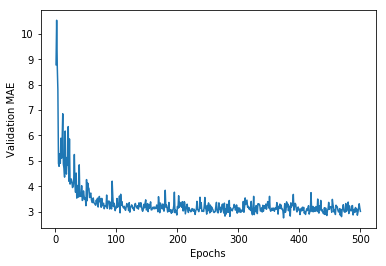

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(1, len(average_mae_history)+1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

It may be a bit hard to see the plot due to scaling issues and relatively high variance. Let's:
  - Omit the first 10 data points, which are on a different scale from the rest of the curve.
  - Replace each point with an exponential moving average of the previous points, to obtain a smooth curve.

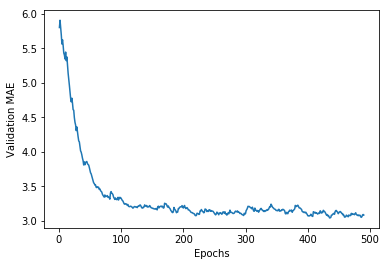

In [24]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()